<a href="https://colab.research.google.com/github/IceHoles/ml/blob/main/practice1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задача 1: Подготовка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import ast  # Модуль для преобразования строки в список
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import drive

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/psn.csv'

# Загрузка файла данных
data = pd.read_csv(file_path)
data = data.astype(str) # Почему-то после чтения тип файлов не определяется как str, поэтому я привожу его к str для последующей обработки и приведения к float если требуется
print(data.columns)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Index(['Ссылка', 'Точный адрес', 'Долгота', 'Широта', 'Ценовая зона',
       'Расстояние до центра', 'Расстояние до метро',
       'Расстояние до остановки', 'Расстояние до школы', 'Расстояние до КАД',
       'Заголовок', 'Описание', 'Тип сделки', 'Город', 'Сегмент', 'Класс',
       'Год постройки_', 'Год постройки', 'Вход', 'Доступ', 'Высота поталков',
       'Назначение', 'Этажей', 'Этажей_', 'Количество просмотров', 'Парковка',
       'Отопление', 'Тип объекта', 'Ремонт', 'Общая площадь, кв.м',
       'Цена, руб', 'Удельная цена руб/кв.м', 'Дата парсинга',
       'Дата создания'],
      dtype='object')


Всего имеем 1733 строки и 34 столбца, но можно заметить, что некоторые из них повторяются, некоторые заполнены разрежено и некоторые не несут полезной информации, например в столбце "Точный адрес" у многих объектов адрес указан просто как "город Санкт-Петербург", что не дает нам никакой уточняющей информации. Удалим их чуть позже

In [ ]:
# Объединение столбцов 'Год постройки_' и 'Год постройки'
data['Год постройки'] = data['Год постройки'].fillna(data['Год постройки_'])

# Объединение столбцов 'Этажей' и 'Этажей_'
data['Этажей'] = data['Этажей'].fillna(data['Этажей_'])

# Преобразование строки в список
data['Ценовая зона'] = data['Ценовая зона'].apply(lambda x: x.split(',')[0].strip("[]'"))

# Создание DataFrame с числовыми и нечисловыми столбцами
numeric_features = ['Долгота', 'Широта', 'Расстояние до центра', 'Год постройки', 'Общая площадь, кв.м', 'Цена, руб', 'Удельная цена руб/кв.м', 'Высота поталков', 'Этажей', 'Количество просмотров']
non_numeric_features = ['Ценовая зона', 'Класс', 'Тип объекта', 'Вход', 'Доступ', 'Назначение', 'Парковка', 'Отопление', 'Ремонт']

# Подсчет количества уникальных значений в каждом столбце
unique_counts = data.nunique()
print(unique_counts)

Ссылка                     1733
Точный адрес                390
Долгота                     488
Широта                      480
Ценовая зона                 10
Расстояние до центра        284
Расстояние до метро         284
Расстояние до остановки     284
Расстояние до школы         284
Расстояние до КАД           273
Заголовок                  1362
Описание                   1179
Тип сделки                    1
Город                         1
Сегмент                       1
Класс                         3
Год постройки_               33
Год постройки                37
Вход                          3
Доступ                        2
Высота поталков               5
Назначение                    2
Этажей                       20
Этажей_                      21
Количество просмотров       156
Парковка                      7
Отопление                     7
Тип объекта                   2
Ремонт                        5
Общая площадь, кв.м         546
Цена, руб                   556
Удельная

Также можно заметить, что имеется много вхождений одинаковых объектов, но с разными датами парсинга и ценами. Как видно из результата data.nunique() у всех строчек ссылки разные, значит нужно поймать дубликаты, основываясь на других столбцах. Я удалю все совпадающие комбинации столбцов 'Точный адрес', 'Долгота', 'Широта', 'Ценовая зона', 'Класс', 'Тип объекта', 'Общая площадь, кв.м', оставляя объект с наименьшей ценой, хотя можно взять среднюю или последнюю цену по дате парсинга. Эта комбинация параметров обеспечивает уникальность объекта, так как другие столбцы либо не заполнены, либо меняются у самих дубликатов, например дата парсинга, количество просмотров или ссылка.

In [ ]:
# Вывести уникальные значения категориальных признаков
for feature in non_numeric_features:
    print(data[feature].value_counts())
    print('\n')

Ценовая зона
Многоквартирная жилая застройка    576
                                   451
Промзоны                           440
Центры деловой активности          111
Зона автомагистралей                66
ИЖС                                 30
Исторический центр города           21
Окраины                             19
nan                                 16
Зеленая зона                         3
Name: count, dtype: int64


Класс
B    785
A    641
C    307
Name: count, dtype: int64


Тип объекта
склад    995
пп       738
Name: count, dtype: int64


Вход
nan     1632
Есть      89
Нет       12
Name: count, dtype: int64


Доступ
nan         1604
Закрытый     129
Name: count, dtype: int64


Назначение
Склад                            995
Производственная недвижимость    738
Name: count, dtype: int64


Парковка
nan                                 1193
Есть                                 315
нет                                  147
Организованная наземная открытая      37
Для грузового т

Отсюда видно, что столбцы Вход, Доступ, Парковка, Отопление, Ремонт заполнены меньше чем на 2/3, имеет смысл их убрать

Также уберу столбцы, которые не буду использовать: адрес и все что с ним связано (Координаты и столбцы "Расстояние до ..."), заголовок, описание, все столбцы, у которых одинаковое значение во всех строчках (Тип сделки, город, сегмент), столбец "Назначение" так как он повторяет суть столбца "Тип объекта".

In [ ]:
# Преобразование строковых значений в числа для столбцов из numeric_features
for feature in numeric_features:
    data[feature] = pd.to_numeric(data[feature].str.replace(',', '.'), errors='coerce')

In [ ]:
# Оценка числовых признаков
print(data[numeric_features].describe())

           Долгота       Широта  Расстояние до центра  Год постройки  \
count  1733.000000  1733.000000           1502.000000     168.000000   
mean     30.283721    59.848453          11270.462319    1990.934524   
std       2.520736     1.337205           9432.642373      50.055196   
min     -74.141931     4.579796              0.000000    1812.000000   
25%      30.315644    59.807224              0.000000    1980.750000   
50%      30.368799    59.887580          13195.890000    2017.000000   
75%      30.414036    59.938955          15154.146620    2020.000000   
max      30.753518    62.723210          66602.727990    2023.000000   

       Общая площадь, кв.м     Цена, руб  Удельная цена руб/кв.м  \
count          1733.000000  1.733000e+03            1.733000e+03   
mean           5185.850000  2.622818e+08            8.054966e+04   
std           10965.728124  5.411521e+08            9.089248e+04   
min               1.300000  5.600000e+04            2.166667e+00   
25%        

Столбцы Год постройки, Высота поталков, Этажей заполнены очень редко, их тоже следует убрать

In [ ]:
# Функция для вычисления расстояния между двумя точками на основе их широты и долготы
def haversine(lat1, lon1):
    R = 6371.0  # Радиус Земли в километрах
    lat1_rad = math.radians(lat1)
    lon1_rad = math.radians(lon1)
    lat2_rad = math.radians(59.938955)
    lon2_rad = math.radians(30.315644)
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    a = math.sin(dlat / 2)**2 + math.cos(lat1_rad) * math.cos(lat2_rad) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

In [ ]:
#Считаем количество строк до удаления дубликатов
num_rows = data.shape[0]
print(f'Количество строк до удаления дубликатов:{num_rows}')

# Удаление дубликатов по всем уникальным отличающимся признакам, оставляю объект с минимальной ценой
data.sort_values(by='Цена, руб', ascending=True, inplace=True)
data.drop_duplicates(subset=['Точный адрес', 'Долгота', 'Широта', 'Ценовая зона', 'Класс', 'Тип объекта', 'Общая площадь, кв.м'], keep='first', inplace=True)

# Вычисление расстояния до центра исходя из столбцов с координатами
data = data[data['Долгота'] > 29]
data['Расстояние до центра'] = data.apply(lambda row: haversine(row['Широта'], row['Долгота']), axis=1)

# Удаление столбцов с неиспользуемыми данными 'Долгота', 'Широта',
non_used_columns = ['Долгота', 'Широта', 'Ссылка', 'Точный адрес', 'Этажей', 'Этажей_', 'Год постройки_', 'Год постройки', 'Расстояние до остановки', 'Расстояние до школы', 'Расстояние до метро', 'Расстояние до КАД', 'Заголовок', 'Описание', 'Тип сделки', 'Город', 'Сегмент', 'Вход', 'Доступ', 'Высота поталков', 'Назначение', 'Парковка', 'Отопление', 'Ремонт', 'Дата парсинга', 'Дата создания']
data = data.drop(columns=non_used_columns)

# Обновление набора столбцов с используемыми числовыми и нечисловыми столбцами
numeric_features = ['Расстояние до центра', 'Общая площадь, кв.м', 'Цена, руб', 'Удельная цена руб/кв.м', 'Количество просмотров']
non_numeric_features = ['Ценовая зона', 'Класс', 'Тип объекта']

print(f'Количество строк после удаления дубликатов:{data.shape[0]}')
print(f'Всего удалено дубликатов:{num_rows - data.shape[0]}')
print(data.columns)

Количество строк до удаления дубликатов:1733
Количество строк после удаления дубликатов:1097
Всего удалено дубликатов:636
Index(['Ценовая зона', 'Расстояние до центра', 'Класс',
       'Количество просмотров', 'Тип объекта', 'Общая площадь, кв.м',
       'Цена, руб', 'Удельная цена руб/кв.м'],
      dtype='object')


In [ ]:
# Вывести значения категориальных признаков
for feature in non_numeric_features:
    print(data[feature].value_counts())
    print('')

# Оценка числовых признаков
print(data[numeric_features].describe())

Ценовая зона
                                   308
Промзоны                           300
Многоквартирная жилая застройка    297
Центры деловой активности           81
Зона автомагистралей                49
ИЖС                                 20
Исторический центр города           16
nan                                 12
Окраины                             12
Зеленая зона                         2
Name: count, dtype: int64

Класс
B    556
A    364
C    177
Name: count, dtype: int64

Тип объекта
склад    645
пп       452
Name: count, dtype: int64

       Расстояние до центра  Общая площадь, кв.м     Цена, руб  \
count           1097.000000          1097.000000  1.097000e+03   
mean              11.604423          5057.948177  2.406912e+08   
std               10.111848         11008.267340  5.204623e+08   
min                0.000000             1.300000  5.600000e+04   
25%                2.001424            63.600000  1.500000e+06   
50%               11.913597          1440.000000 

В ценовых зонах целесообразно оставить "Промзоны", "Многоквартирная жилая застройка", а остальные категории обединить в одну.

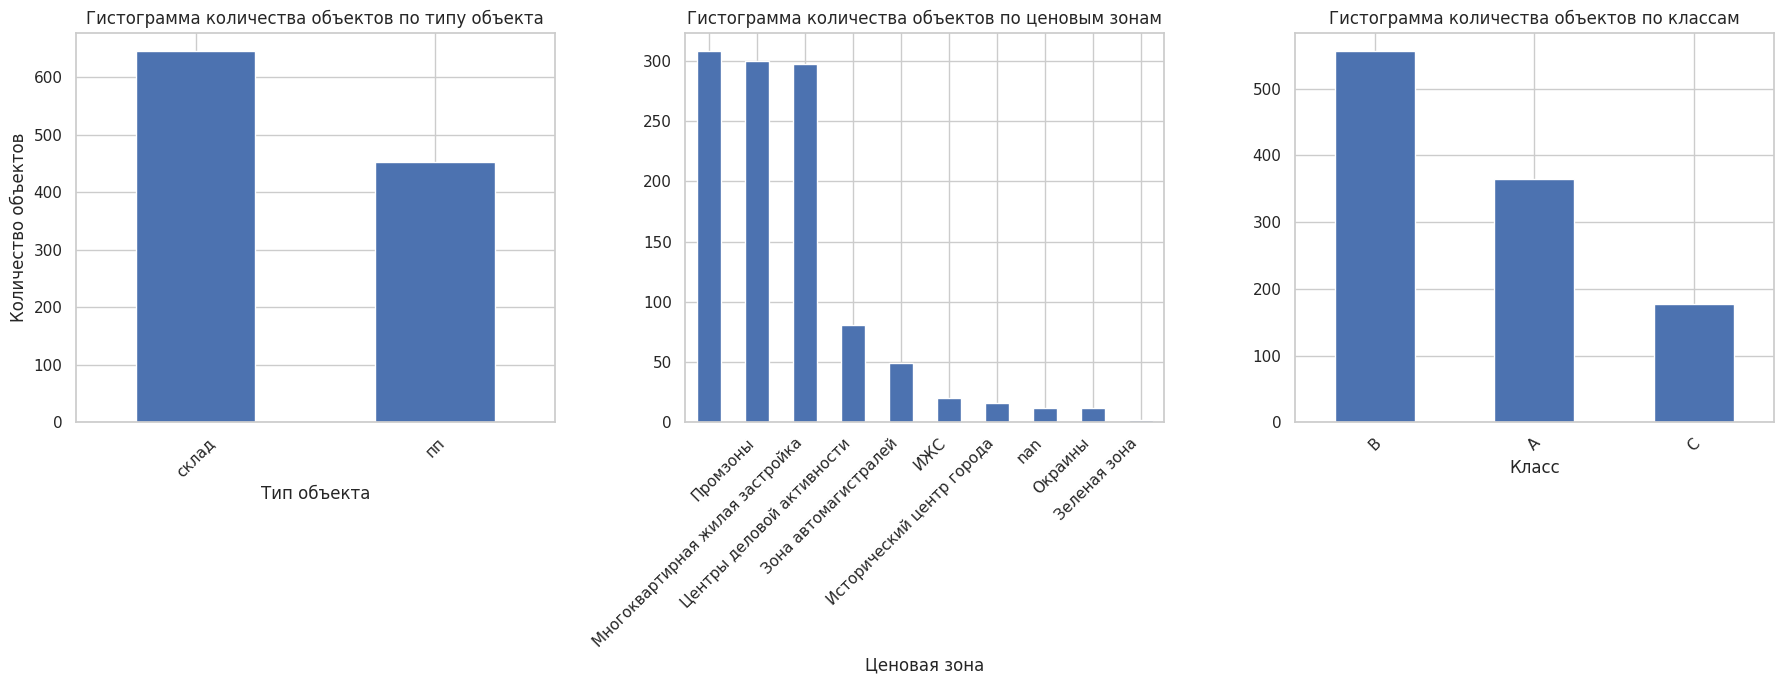

In [ ]:
# Построение столбиковых диаграмм для категориальных признаков
fig, axs = plt.subplots(1, 3, figsize=(18, 7))

ax = axs[0]
data['Класс'].value_counts().plot(kind='bar')
plt.title('Гистограмма количества объектов по классам')
plt.xticks(rotation=45)
plt.sca(ax)

ax = axs[1]
data['Тип объекта'].value_counts().plot(kind='bar')
plt.title('Гистограмма количества объектов по типу объекта')
plt.ylabel('Количество объектов')
plt.xticks(rotation=45)
plt.sca(ax)

ax = axs[2]
data['Ценовая зона'].value_counts().plot(kind='bar')
plt.title('Гистограмма количества объектов по ценовым зонам')
plt.xticks(rotation=45, ha='right')
plt.sca(ax)
plt.tight_layout()  # Улучшает расположение графиков в сетке
plt.show()

Как мы видим, типы объектов разделяются на склады и производственную недвижимость, и им присущи совершенно разные признаки, возможно имеет смысл оценивать их раздельно

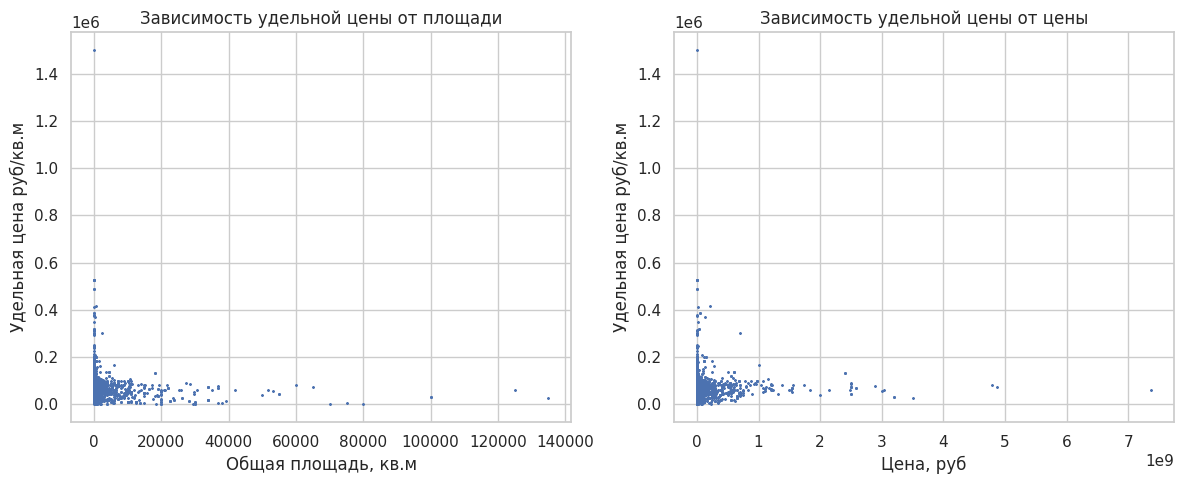

In [ ]:
#Построение зависимости удельной цены от площади
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax = axs[0]
plt.sca(ax)
plt.scatter(data['Общая площадь, кв.м'], data['Удельная цена руб/кв.м'], s=1, marker='X')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Удельная цена руб/кв.м')
plt.title('Зависимость удельной цены от площади')

ax = axs[1]
plt.sca(ax)
plt.scatter(data['Цена, руб'], data['Удельная цена руб/кв.м'], s=1, marker='X')
plt.xlabel('Цена, руб')
plt.ylabel('Удельная цена руб/кв.м')
plt.title('Зависимость удельной цены от цены')
plt.tight_layout()
plt.show()

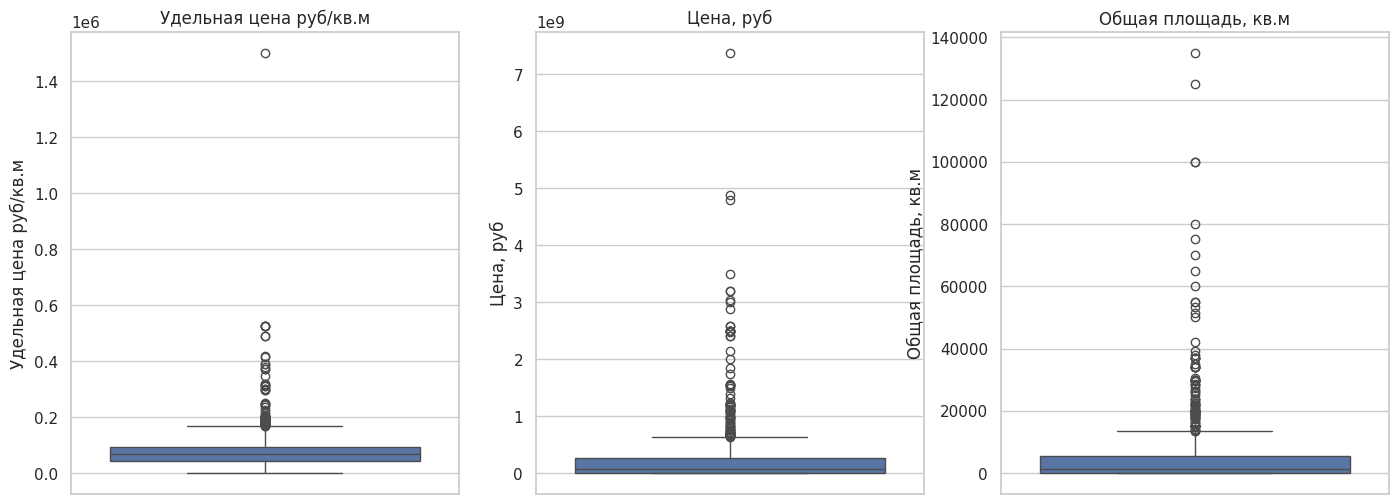

In [ ]:
sns.set(style="whitegrid")

# Выбираем столбцы для анализа
columns_to_analyze = ['Удельная цена руб/кв.м', 'Цена, руб', 'Общая площадь, кв.м']

# Создаем боксплоты для каждого столбца
plt.figure(figsize=(17, 6))
for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(1, len(columns_to_analyze), i)
    sns.boxplot(y=data[column])
    plt.title(f'{column}')

plt.show()

На графиках можно заметить точки, сильно отдаленные от основной массы, уберем все что не попадает в интерквантильный размах

Удалено строк с выбросами: 200


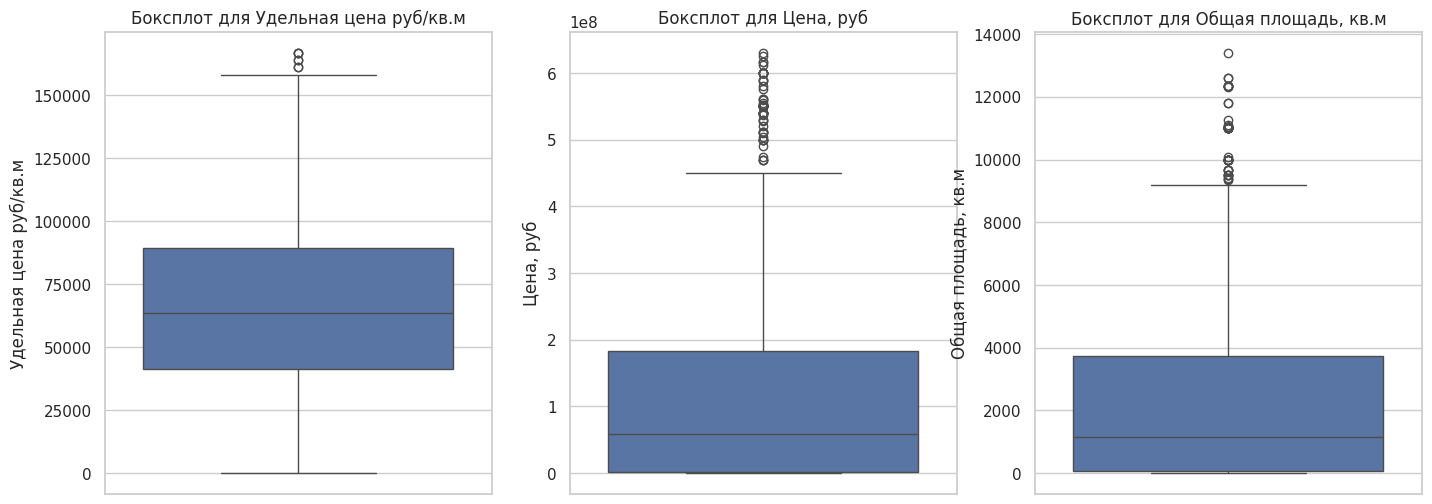

Количество строк после удаления выбросов:897


In [ ]:
df = data

columns_to_analyze = ['Удельная цена руб/кв.м', 'Цена, руб', 'Общая площадь, кв.м']

# Задаем порог для определения выбросов
outlier_threshold = 1.5

# Создаем копию DataFrame, чтобы не изменять оригинал
df_no_outliers = df.copy()

# Удаляем строки с выбросами
for column in columns_to_analyze:
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - outlier_threshold * iqr
    upper_bound = q3 + outlier_threshold * iqr

    df_no_outliers = df_no_outliers[(df_no_outliers[column] >= lower_bound) & (df_no_outliers[column] <= upper_bound)]
# df_no_outliers = df_no_outliers[df_no_outliers['Долгота'] > 29]
# Выводим информацию о том, сколько строк удалено
print(f"Удалено строк с выбросами: {len(df) - len(df_no_outliers)}")

# Выводим боксплоты после удаления выбросов
plt.figure(figsize=(17, 6))
for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(1, len(columns_to_analyze), i)
    sns.boxplot(y=df_no_outliers[column].dropna())
    plt.title(f'Боксплот для {column}')

plt.show()
print(f'Количество строк после удаления выбросов:{df_no_outliers.shape[0]}')

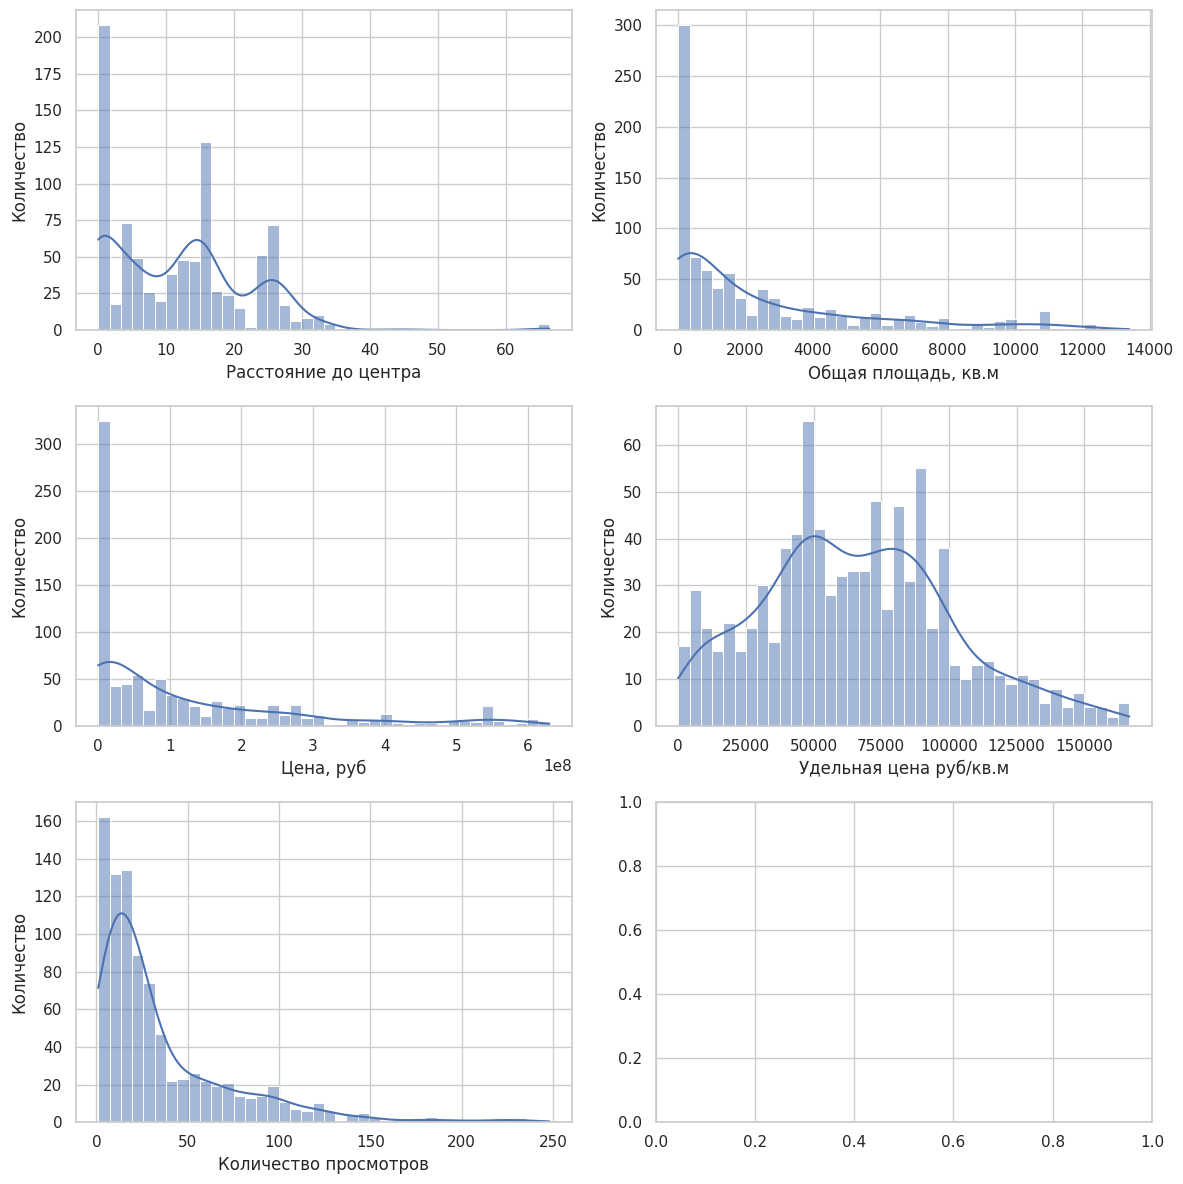

In [ ]:
# Построение гистограмм для числовых признаков
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
i = 0
for feature in numeric_features:
    ax = axs[i // 2, i % 2]
    sns.histplot(data=df_no_outliers, x=feature, bins=40, kde=True, ax=ax)
    #ax.set_title(f'Гистограмма для {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Количество')
    i += 1
plt.tight_layout()
plt.show()

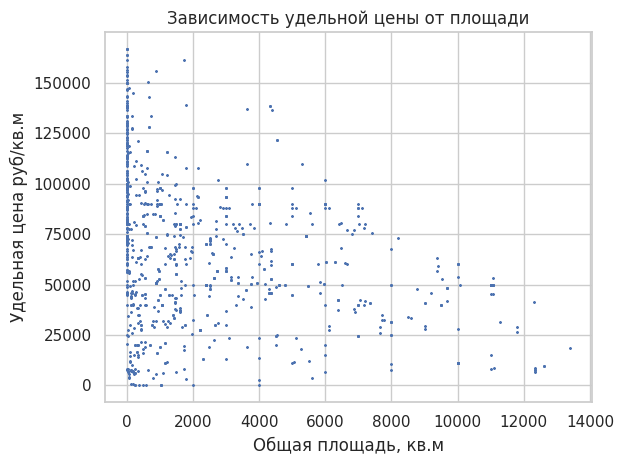

In [ ]:
#Построение зависимости удельной цены от площади
plt.scatter(df_no_outliers['Общая площадь, кв.м'], df_no_outliers['Удельная цена руб/кв.м'], s=1, marker='X')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Удельная цена руб/кв.м')
plt.title('Зависимость удельной цены от площади')
plt.tight_layout()
plt.show()

Скопление у нуля по площади отображает преимущественно складскую недвижимость, построим раздельные графики для складской недвижимости и производственных помещений

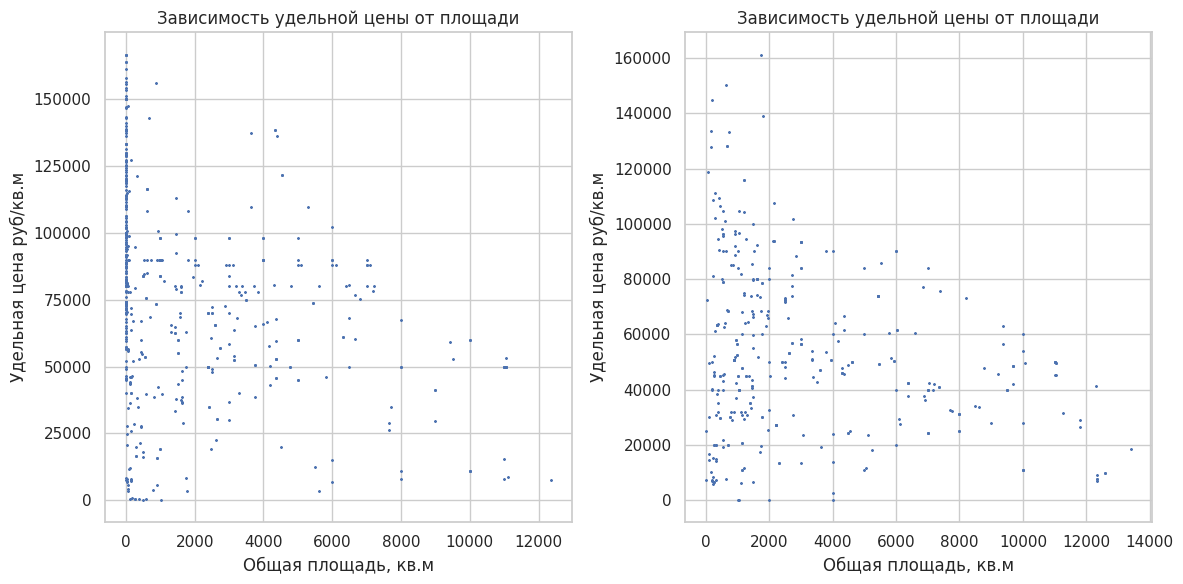

In [ ]:
# Выбираем данные по типам объектов
df_warehouse = df_no_outliers[df_no_outliers['Тип объекта'] == 'склад']
df_pp = df_no_outliers[df_no_outliers['Тип объекта'] == 'пп']

plt.figure(figsize=(12, 6))

#Построение зависимости удельной цены от площади
plt.subplot(1, 2, 1)
plt.scatter(df_warehouse['Общая площадь, кв.м'], df_warehouse['Удельная цена руб/кв.м'], s=1, marker='X')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Удельная цена руб/кв.м')
plt.title('Зависимость удельной цены от площади')

plt.subplot(1, 2, 2)
plt.scatter(df_pp['Общая площадь, кв.м'], df_pp['Удельная цена руб/кв.м'], s=1, marker='X')
plt.xlabel('Общая площадь, кв.м')
plt.ylabel('Удельная цена руб/кв.м')
plt.title('Зависимость удельной цены от площади')

plt.tight_layout()
plt.show()

### Задача 2: Анализ параметров

In [ ]:
for feature in non_numeric_features:
    # Группировка данных по категории
    grouped_data = df_no_outliers.groupby(feature)
    # Вычисление среднего, медианы, максимума и минимума удельной цены в каждой категории
    statistics = grouped_data['Удельная цена руб/кв.м'].agg(['mean', 'median', 'max', 'min'])
    print('Удельная цена руб/кв.м')
    print(statistics)

Удельная цена руб/кв.м
                                         mean      median         max  \
Ценовая зона                                                            
                                 68461.195938  66574.8360  166666.670   
nan                              74824.758436  79925.6500  127142.860   
Зеленая зона                     18095.238000  18095.2380   18095.238   
Зона автомагистралей             63780.392229  72400.0000  143072.300   
ИЖС                              63162.573214  51635.2265  115833.336   
Исторический центр города        67680.127333  72006.6330  133333.330   
Многоквартирная жилая застройка  78128.801955  81081.0800  166666.670   
Окраины                          30692.405489  24444.4410   68702.290   
Промзоны                         55402.867995  50000.0000  161281.030   
Центры деловой активности        57939.075014  50000.0000  163934.420   

                                         min  
Ценовая зона                                  
      

Из средних значений по катеоргиям видно, что у складов, удельная цена выше чем у производственной недвижимости, класс А дороже чем класс B, а он дороже класса C.

In [ ]:
# Создание кросс-таблицы для ценовых зон и классов
cross_tab = pd.crosstab(df_no_outliers['Ценовая зона'], df_no_outliers['Класс'])
print(cross_tab)

Класс                              A    B   C
Ценовая зона                                 
                                  74  138  29
nan                                3    6   1
Зеленая зона                       0    1   0
Зона автомагистралей               8   29   5
ИЖС                                2    9   3
Исторический центр города          4    5   3
Многоквартирная жилая застройка  103  116  26
Окраины                            0    6   3
Промзоны                          64  122  66
Центры деловой активности         16   46   9


In [ ]:
# Создание сводной таблицы для средней цены по ценовым зонам и классам
pivot_table = df_no_outliers.pivot_table(values='Удельная цена руб/кв.м', index='Тип объекта', columns='Класс', aggfunc='mean')
print(pivot_table)

Класс                   A             B             C
Тип объекта                                          
пп           59029.727074  51617.839515  49339.317272
склад        75513.678021  78692.829577  62845.954854


### Задача 3: Построение моделей линейной регрессии

Я думаю, что качественное влияние на цену будут оказывать признаки: 'Ценовая зона', 'Класс', 'Тип объекта', 'Общая площадь, кв.м', 'Удельная цена руб/кв.м'

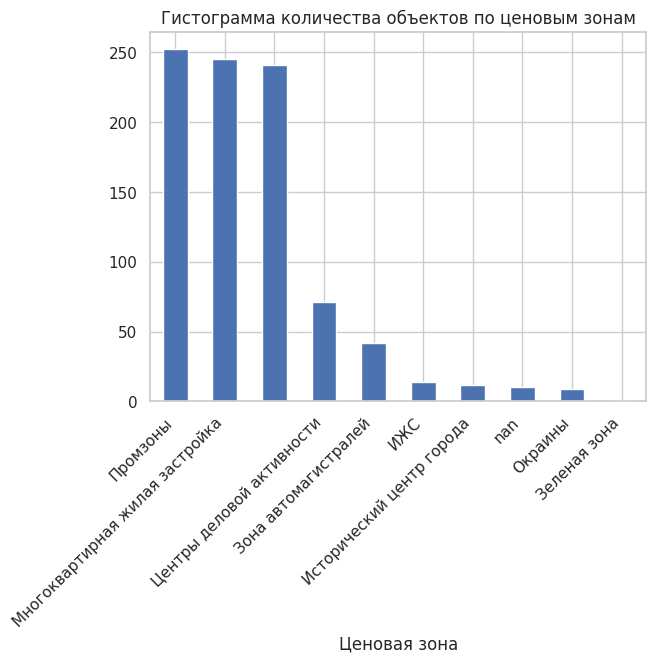

Ценовая зона
Промзоны                           252
Многоквартирная жилая застройка    245
                                   241
Центры деловой активности           71
Зона автомагистралей                42
ИЖС                                 14
Исторический центр города           12
nan                                 10
Окраины                              9
Зеленая зона                         1
Name: count, dtype: int64


In [ ]:
df_no_outliers['Ценовая зона'].value_counts().plot(kind='bar')
plt.title('Гистограмма количества объектов по ценовым зонам')
plt.xticks(rotation=45, ha='right')
plt.show()

print(df_no_outliers['Ценовая зона'].value_counts())

Так как пустых значений очень много, оставим их как отдельный признак, так же добавим туда все зоны, встречающиеся реже 7%

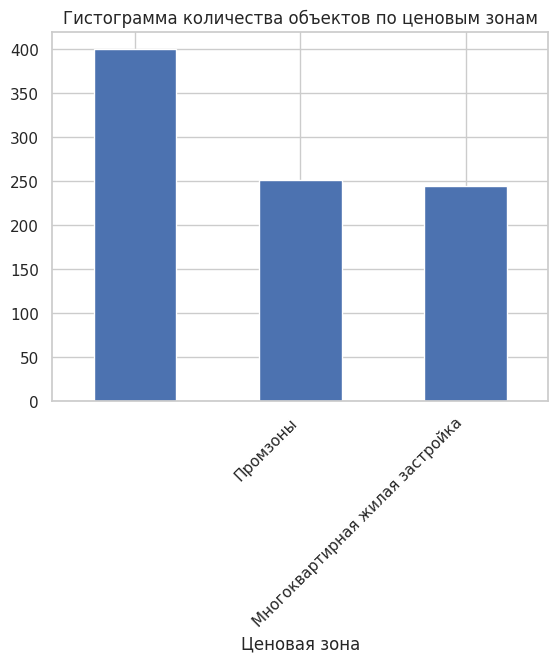

Ценовая зона
                                   400
Промзоны                           252
Многоквартирная жилая застройка    245
Name: count, dtype: int64


In [ ]:
values_to_replace = ['Окраины', 'nan', 'Исторический центр города', 'ИЖС', 'Зона автомагистралей', 'Центры деловой активности', 'Зеленая зона']
df_no_outliers['Ценовая зона'] = df_no_outliers['Ценовая зона'].replace(values_to_replace, '')
df_no_outliers['Ценовая зона'].value_counts().plot(kind='bar')
plt.title('Гистограмма количества объектов по ценовым зонам')
plt.xticks(rotation=45, ha='right')
plt.show()
print(df_no_outliers['Ценовая зона'].value_counts())

Теперь можно закодировать параметры и построить модель линейной регрессии

In [ ]:
def mdape(y_true, y_pred):
    """
    Вычисляет Median Absolute Percentage Error (MdAPE).

    Параметры:
    - y_true: фактические значения
    - y_pred: предсказанные значения
    """
    error = np.abs((y_true - y_pred) / y_true) * 100
    return np.median(error)

In [ ]:
dft = df_no_outliers
# dft = dft[dft['Тип объекта'] == 'пп']
# dft = dft.drop(columns = 'Тип объекта')
dft = dft.drop(columns = 'Количество просмотров')
dft = dft.drop(columns = 'Цена, руб')
# Применить логарифм к удельной цене
# dft['Удельная цена руб/кв.м'] = np.log1p(dft['Удельная цена руб/кв.м'])

X = dft.drop('Удельная цена руб/кв.м', axis=1)
y = dft['Удельная цена руб/кв.м']
print(X.columns)
# Разделяем данные на обучающую и тестовую выборки (75% и 25%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Заменить классы на среднее значение удельной цены в классе
class_means_train = dft.groupby('Класс')['Удельная цена руб/кв.м'].mean()
X_train['Класс'] = X_train['Класс'].map(class_means_train)
X_test['Класс'] = X_test['Класс'].map(class_means_train)

# Создать интервалы для площади и преобразовать ее в категориальный признак
bins = [0, 100, 200, 2000, 6000, 135000]
labels = ['Очень маленькие', 'Маленькие', 'Средние', 'Большие', 'Очень большие']
X_train['Площадь интервал'] = pd.cut(X_train['Общая площадь, кв.м'], bins=bins, labels=labels)
X_test['Площадь интервал'] = pd.cut(X_test['Общая площадь, кв.м'], bins=bins, labels=labels)

# Стандартизация числовых признаков
numeric_features = ['Расстояние до центра', 'Класс'] # 'Цена, руб',
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Применить One-Hot Encoding для Категориальных признаков
X_train = pd.get_dummies(X_train, columns=['Площадь интервал'], prefix='Площадь интервал')
X_train = pd.get_dummies(X_train, columns=['Ценовая зона'], prefix='Ценовая_зона')
X_train = pd.get_dummies(X_train, columns=['Тип объекта'], prefix='Тип_объекта')
X_test = pd.get_dummies(X_test, columns=['Площадь интервал'], prefix='Площадь интервал')
X_test = pd.get_dummies(X_test, columns=['Ценовая зона'], prefix='Ценовая_зона')
X_test = pd.get_dummies(X_test, columns=['Тип объекта'], prefix='Тип_объекта')

Index(['Ценовая зона', 'Расстояние до центра', 'Класс', 'Тип объекта',
       'Общая площадь, кв.м'],
      dtype='object')


Применение логарифма к целевому признаку сильно уменьшает R-квадрат, не буду его использовать

In [ ]:
# Создаем и обучаем модель линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказываем значения для тестовой выборки
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

# Оценка производительности модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mdape_l = mdape(y_test, y_pred)

# Вычисляем MdAPE для Liear Regression
mdape_linear = mdape(y_train, y_train_pred)

print(f'Median Absolute Percentage Error (MdAPE) на обучающих данных: {mdape_linear:.2f}%')
print(f'MdAPE для линейной регрессии: {mdape_l:.2f}%')
print(f'Среднеквадратическое отклонение: {mse:.2f}')
print(f'R-квадрат: {r2:.2f}')

Median Absolute Percentage Error (MdAPE) на обучающих данных: 26.43%
MdAPE для линейной регрессии: 30.24%
Среднеквадратическое отклонение: 1116892658.22
R-квадрат: 0.18


Аналогично поступим для модели регрессии Лассо и Ридж

In [ ]:
# Lasso Regression
lasso_params = {'alpha': [1, 10, 25, 35, 50, 75, 100]}
lasso = Lasso()
lasso_grid = GridSearchCV(lasso, lasso_params, cv=7)
lasso_grid.fit(X_train, y_train)

# Ridge Regression
ridge_params = {'alpha': [0.1, 0.3, 0.5, 1, 3, 5, 10]}
ridge = Ridge()
ridge_grid = GridSearchCV(ridge, ridge_params, cv=9)
ridge_grid.fit(X_train, y_train)

# Лучшие параметры
best_alpha_lasso = lasso_grid.best_params_['alpha']
best_alpha_ridge = ridge_grid.best_params_['alpha']

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.854e+10, tolerance: 6.777e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.987e+09, tolerance: 7.249e+07
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.668e+09, tolerance: 6.941e

In [ ]:
# Обучение моделей с лучшими параметрами
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)

ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)

# Стохастический градиентный спуск
sgd_model = SGDRegressor(alpha=best_alpha_lasso, random_state=42)
sgd_model.fit(X_train, y_train)

# Предсказываем значения для тестовой выборки
y_pred_lasso = lasso_model.predict(X_test)
y_pred_ridge = ridge_model.predict(X_test)
y_pred_sgd = sgd_model.predict(X_test)

# Оценка производительности моделей
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
mdape_las = mdape(y_train, lasso_model.predict(X_train))

mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
mdape_rid = mdape(y_train, ridge_model.predict(X_train))

print("Best Alpha for Lasso:", best_alpha_lasso)
print("Best Alpha for Ridge:", best_alpha_ridge)

print("\nЛассо регрессия:")
print(f'Среднеквадратическое отклонение: {mse_lasso:.2f}')
print(f'R-квадрат: {r2_lasso:.2f}')
print(f'MdAPE на обучающих данных: {mdape_las:.2f}%')

print("\nРидж регрессия:")
print(f'Среднеквадратическое отклонение: {mse_ridge:.2f}')
print(f'R-квадрат: {r2_ridge:.2f}')
print(f'MdAPE на обучающих данных: {mdape_rid:.2f}%')

Best Alpha for Lasso: 100
Best Alpha for Ridge: 5

Лассо регрессия:
Среднеквадратическое отклонение: 1107198836.63
R-квадрат: 0.19
MdAPE на обучающих данных: 26.29%

Ридж регрессия:
Среднеквадратическое отклонение: 1099850851.42
R-квадрат: 0.20
MdAPE на обучающих данных: 26.51%


Сравним модели

In [ ]:
# Вычисляем MdAPE
mdape_lasso = mdape(y_test, y_pred_lasso)
mdape_ridge = mdape(y_test, y_pred_ridge)
mdape_linear = mdape(y_test, y_pred)

print(f'MdAPE для линейной регрессии: {mdape_linear:.2f}%')
print(f'MdAPE для Лассо регрессии: {mdape_lasso:.2f}%')
print(f'MdAPE для Ридж регрессии: {mdape_ridge:.2f}%')

MdAPE для линейной регрессии: 30.24%
MdAPE для Лассо регрессии: 29.68%
MdAPE для Ридж регрессии: 29.36%


Лучшей моделью по признаку MdAPE оказалась Ридж регрессия, но этот результат непостоянен из-за стохастической натуры метода

В ходе различных экспериментов я подобрал лучшие параметры для лассо и ридж регрессий, так же пришёл к текущему набору признаков

Добавление Широты и Долготы уменьшило R-квадрат на 0.07, MdAPE уменьшилась на 1%

### Задача 4: KNN и Дерево принятия решений

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


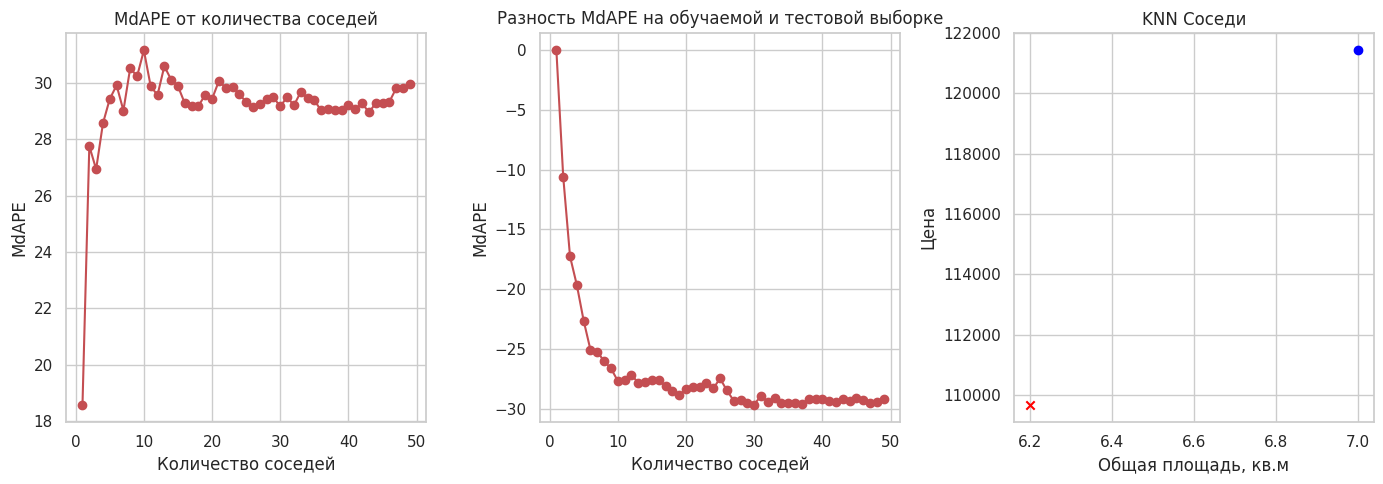


KNN для 1 соседей
Лучшее количество соседей: 1
Среднеквадратическое отклонение: 1286552383.28
R-квадрат: 0.06
MdAPE на обучающих данных: 0.00%
MdAPE на тестовых данных: 18.41%


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer
# Зададим диапазон значений для параметра n_neighbors
param_grid = {'n_neighbors': np.arange(1, 50)}

# Определим метрику для использования в GridSearchCV
scorer = make_scorer(mdape, greater_is_better=False)
knn_model = KNeighborsRegressor(weights='uniform', p=1)

# Создадим объект GridSearchCV
grid_search = GridSearchCV(knn_model, param_grid, scoring=scorer, refit=True, cv=5, return_train_score = True)
grid_search.fit(X_train, y_train)
# Найдём лучшие параметры
best_n_neighbors = grid_search.best_params_['n_neighbors']

# Построим график зависимости MdAPE от количества соседей
results = grid_search.cv_results_

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
ax = axs[0]
plt.sca(ax)
plt.plot(results['param_n_neighbors'], -results['mean_test_score'], marker='o', color = 'r')
plt.title('MdAPE от количества соседей')
plt.xlabel('Количество соседей')
plt.ylabel('MdAPE')

ax = axs[1]
plt.sca(ax)
plt.plot(results['param_n_neighbors'], results['split0_train_score'], marker='o', color = 'r')
plt.title('Разность MdAPE на обучаемой и тестовой выборке')
plt.xlabel('Количество соседей')
plt.ylabel('MdAPE')

# Предсказание значений для тестовой выборки
best_knn_model = KNeighborsRegressor(n_neighbors=best_n_neighbors)
best_knn_model.fit(X_train, y_train)
y_pred_knn = best_knn_model.predict(X_test)

# Выберем несколько точек из тестовой выборки для визуализации соседей
num_points_to_visualize = 1
selected_points_indices = np.random.choice(X_test.shape[1], num_points_to_visualize, replace=False)
selected_points = X_test.iloc[selected_points_indices].to_numpy()

# Получим индексы ближайших соседей для выбранных точек
distances, k_neighbors_indices = best_knn_model.kneighbors(selected_points)
ax = axs[2]
plt.sca(ax)
col = 2
# Визуализация выбранных точек и их соседей
for i in range(num_points_to_visualize):
    # Визуализация выбранной точки
    plt.scatter(selected_points[i, col], y_test.iloc[selected_points_indices[i]], color='blue', marker='o')
    # Визуализация соседей
    plt.scatter(X_train.iloc[k_neighbors_indices[i], col], y_train.iloc[k_neighbors_indices[i]], color='red', marker='x')
plt.title(f'KNN Соседи')
plt.xlabel(f'{X_train.columns[col]}')
plt.ylabel(f'Цена')
plt.tight_layout()
plt.show()

# Оценка производительности модели k-nn
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
mdape_knn = mdape(y_train, best_knn_model.predict(X_train))
mdape_knn_test = mdape(y_test, best_knn_model.predict(X_test))

print(f'\nKNN для {best_n_neighbors} соседей')
print("Лучшее количество соседей:", best_n_neighbors)
print(f'Среднеквадратическое отклонение: {mse_knn:.2f}')
print(f'R-квадрат: {r2_knn:.2f}')
print(f'MdAPE на обучающих данных: {mdape_knn:.2f}%')
print(f'MdAPE на тестовых данных: {mdape_knn_test:.2f}%')

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# Параметры для подбора
param_grid = {
#    'max_depth': [5, 7, 9, 10, 18, 20, 23, 27],
    'max_depth': [5, 7, 9, 10, 27],
    'min_samples_split': [2, 3, 4, 5, 6, 10],
    'min_samples_leaf': [1, 3, 6, 9, 12, 15]
}

# Определим метрику для использования в GridSearchCV
scorer = make_scorer(mdape, greater_is_better=False)

# Создание модели дерева решений
tree_model = DecisionTreeRegressor(random_state=42)

# Инициализация GridSearchCV
grid_search = GridSearchCV(tree_model, param_grid, scoring=scorer, cv=5, return_train_score = True)

# Подгонка модели
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров
best_params_tree = grid_search.best_params_

# Предсказание значений для тестовой выборки с лучшими параметрами
y_pred_tree_cv = grid_search.predict(X_test)

# Оценка производительности модели дерева решений с лучшими параметрами
mse_tree_cv = mean_squared_error(y_test, y_pred_tree_cv)
r2_tree_cv = r2_score(y_test, y_pred_tree_cv)
mdape_tree_cv = mdape(y_train, grid_search.predict(X_train))
mdape_tree_test = mdape(y_test, y_pred_tree_cv)

print("Дерево решений с кросс-валидацией:")
print(f'Лучшие параметры: {best_params_tree}')
print(f'Среднеквадратическое отклонение: {mse_tree_cv:.2f}')
print(f'R-квадрат: {r2_tree_cv:.2f}')
print(f'MdAPE на обучающих данных: {mdape_tree_cv:.2f}%')
print(f'MdAPE для дерева принятия решений: {mdape_tree_test:.2f}%')

Дерево решений с кросс-валидацией:
Лучшие параметры: {'max_depth': 27, 'min_samples_leaf': 1, 'min_samples_split': 2}
Среднеквадратическое отклонение: 1410226917.84
R-квадрат: -0.03
MdAPE на обучающих данных: 0.00%
MdAPE для дерева принятия решений: 24.26%


In [ ]:
# Функция для построения графика зависимости MdAPE от параметра
def plot_dependency(param_values, param_name, fancy_name):
    params = {
        'max_depth': [best_params_tree['max_depth']],
        'min_samples_split': [best_params_tree['min_samples_split']],
        'min_samples_leaf': [best_params_tree['min_samples_leaf']]
    }
    params[param_name] = param_values
    grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), params, scoring=scorer, cv=5, return_train_score = True)
    grid_search_cv.fit(X_train, y_train)
    mdape_values = -grid_search_cv.cv_results_ ['mean_test_score']
    plt.plot(param_values, mdape_values, marker='o', linestyle='-')
    plt.title(f'Зависимость MdAPE  от параметра \'{fancy_name}\'')
    plt.xlabel(fancy_name)
    plt.ylabel('MdAPE (%)')
    plt.grid(True)

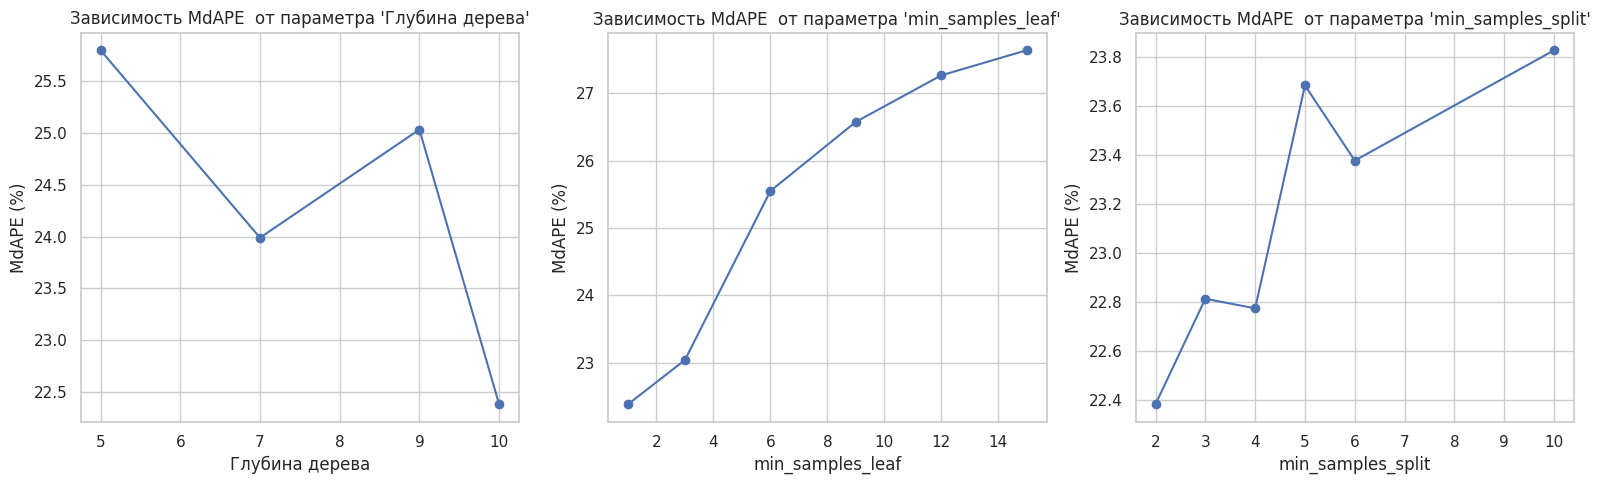

In [ ]:
# Инициализация параметров для построения графиков
depth_values = param_grid['max_depth']
min_samples_leaf_values = param_grid['min_samples_leaf']
min_samples_split_values = param_grid['min_samples_split']

# Построение графика зависимости от max_depth
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
ax = axs[0]
plt.sca(ax)
plot_dependency(depth_values, 'max_depth', 'Глубина дерева')

# Построение графика зависимости от min_samples_leaf
ax = axs[1]
plt.sca(ax)
plot_dependency(min_samples_leaf_values, 'min_samples_leaf', 'min_samples_leaf')

# Построение графика зависимости от min_samples_split
ax = axs[2]
plt.sca(ax)
plot_dependency(min_samples_split_values, 'min_samples_split', 'min_samples_split')
plt.tight_layout()
plt.show()

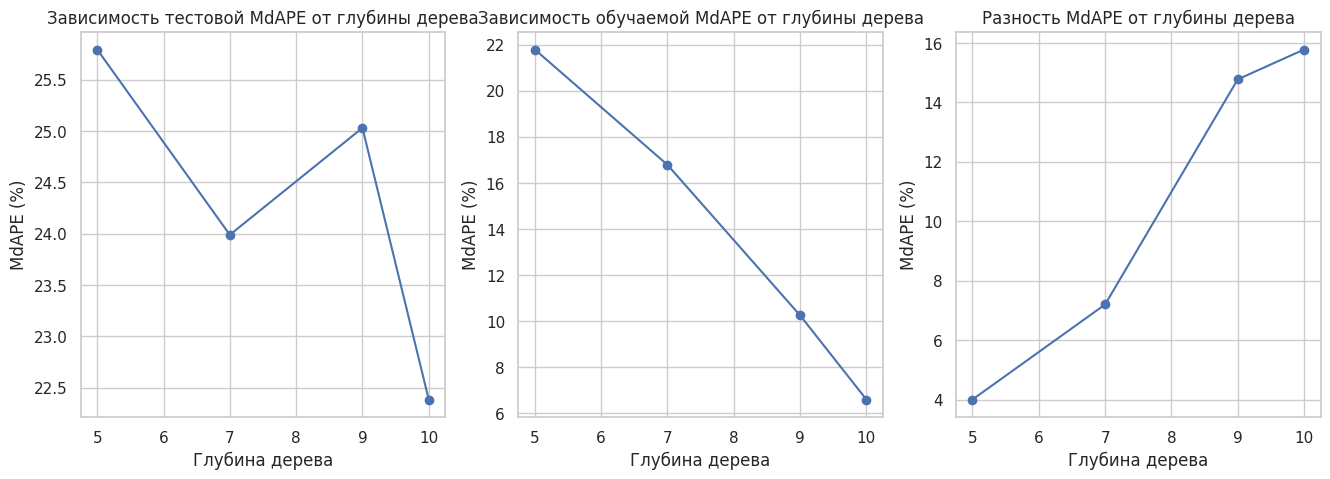

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
ax = axs[0]
plt.sca(ax)
params = {
        'max_depth': [best_params_tree['max_depth']],
        'min_samples_split': [best_params_tree['min_samples_split']],
        'min_samples_leaf': [best_params_tree['min_samples_leaf']]
    }
params['max_depth'] = depth_values
grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), params, scoring=scorer, cv=5, return_train_score = True)
grid_search_cv.fit(X_train, y_train)
mdape_values = -grid_search_cv.cv_results_ ['mean_test_score']
plt.plot(depth_values, mdape_values, marker='o', linestyle='-')
plt.title(f'Зависимость тестовой MdAPE от глубины дерева')
plt.xlabel('Глубина дерева')
plt.ylabel('MdAPE (%)')
plt.grid(True)

ax = axs[1]
plt.sca(ax)
params = {
        'max_depth': [best_params_tree['max_depth']],
        'min_samples_split': [best_params_tree['min_samples_split']],
        'min_samples_leaf': [best_params_tree['min_samples_leaf']]
    }
params['max_depth'] = depth_values
grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), params, scoring=scorer, cv=5, return_train_score = True)
grid_search_cv.fit(X_train, y_train)
mdape_values = -grid_search_cv.cv_results_ ['mean_train_score']
plt.plot(depth_values, mdape_values, marker='o', linestyle='-')
plt.title(f'Зависимость обучаемой MdAPE от глубины дерева')
plt.xlabel('Глубина дерева')
plt.ylabel('MdAPE (%)')
plt.grid(True)

ax = axs[2]
plt.sca(ax)
params = {
        'max_depth': [best_params_tree['max_depth']],
        'min_samples_split': [best_params_tree['min_samples_split']],
        'min_samples_leaf': [best_params_tree['min_samples_leaf']]
    }
params['max_depth'] = depth_values
grid_search_cv = GridSearchCV(DecisionTreeRegressor(random_state=42), params, scoring=scorer, cv=5, return_train_score = True)
grid_search_cv.fit(X_train, y_train)
mdape_values = -grid_search_cv.cv_results_ ['mean_test_score'] + grid_search_cv.cv_results_ ['mean_train_score']
plt.plot(depth_values, mdape_values, marker='o', linestyle='-')
plt.title(f'Разность MdAPE от глубины дерева')
plt.xlabel('Глубина дерева')
plt.ylabel('MdAPE (%)')
plt.grid(True)